In [2]:
from __future__ import absolute_import, division, print_function
import os, sys
import logging
import gzip

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import re
import ast
import json
import collections

# Settings
The time_zone variable will be used when converting the timestamp form UTC time to your local time.

In [3]:
time_zone = 'US/Eastern'
log_version = '2.0'
time_bins_size = '1min'

proximity_data_filename = "proximity.txt.gz"
hub_log_filename = "local_file_hub_20_mar_1242pm.log.gz"
data_dir = "/home/abhishek/Desktop/exp-analysis/hub_data"

In [4]:
log_pattern = re.compile("^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d+ - \w+ - .*$")

def _is_legal_log_line(line):
    return log_pattern.match(line) is not None

def _hublog_read_scan_line(line):
    
    # Removing ANSI from line (colors)
    ansi_escape = re.compile(r'\x1B\[[0-?]*[ -/]*[@-~]')
    line = ansi_escape.sub('', line)

    # remove end of line
    line = line.rstrip("\n\r")

    # Filter out rows with illegal structure
    if not _is_legal_log_line(line):
        return None


    # parse
    data = line.split(" - ")[2]

    if not data.startswith("Found"):
        return None

    scan_data = {}
    adv_payload_raw = data.split("adv_payload': ")[1][0:-1]
    adv_payload = ast.literal_eval(adv_payload_raw)

    if not adv_payload:
        adv_payload = {'proximity_status': None, \
                       'sync_status': None, \
                       'audio_status': None, \
                       'mac': None, \
                       'badge_id': None, \
                       'voltage': None, \
                       'status_flags': None, \
                       'project_id': None}

    scan_data.update(adv_payload)
    scan_data['mac'] = data.split(" ")[1][0:-1]
    scan_data['rssi'] = data.split(": ")[2].split(",")[0]
    scan_data['datetime'] = line.split(" - ")[0]
    scan_data['adv_payload'] = re.sub('[ :\'\[]', '', adv_payload_raw)  # shortenning it
    return scan_data

In [5]:
def hublog_scans(fileobject, log_tz, tz='US/Eastern'):

    def readfile(fileobject):
        for line in fileobject:
            data = _hublog_read_scan_line(line)
            if data:
                yield (data['datetime'],
                       str(data['mac']),
                       float(data['rssi']),
                       data['voltage'],
                       data['badge_id'],
                       data['project_id'],
                       data['sync_status'],
                       data['audio_status'],
                       data['proximity_status'],
                       )
            else:
                continue

    df = pd.DataFrame(readfile(fileobject),columns=['datetime', 'mac', 'rssi', 'voltage', 'badge_id', \
                                                     'project_id', 'sync_status', 'audio_status', \
                                                     'proximity_status'])

    return df

In [6]:
with gzip.open(os.path.join(data_dir, hub_log_filename), 'r') as f:
    table = hublog_scans(f, time_bins_size, tz=time_zone)

In [18]:
table

,datetime,mac,rssi,voltage,badge_id,project_id,sync_status,audio_status,proximity_status
0,"2018-03-14 19:04:31,116",EE:2A:D2:F0:8D:29,-58.0,3.15,4388.0,0.0,0.0,0.0,0.0
1,"2018-03-14 19:04:31,117",DC:C0:DE:26:23:D2,-76.0,3.15,46437.0,0.0,0.0,0.0,0.0
2,"2018-03-14 19:04:31,119",C8:CA:83:BE:F4:C6,-68.0,3.17,7115.0,0.0,0.0,0.0,0.0
3,"2018-03-14 19:04:46,557",CB:4A:90:1E:6B:23,-68.0,3.17,19263.0,0.0,0.0,0.0,0.0
4,"2018-03-14 19:04:46,559",E0:FC:7A:4E:24:77,-69.0,3.14,31474.0,0.0,0.0,0.0,0.0
5,"2018-03-14 19:04:46,564",DE:83:8F:7F:42:5E,-66.0,3.18,20036.0,0.0,0.0,0.0,0.0
6,"2018-03-14 19:04:46,565",EF:13:E7:6B:B2:4E,-77.0,3.15,46739.0,0.0,0.0,0.0,0.0
7,"2018-03-14 19:05:06,480",EE:2A:D2:F0:8D:29,-76.0,3.17,5.0,45.0,1.0,1.0,1.0
8,"2018-03-14 19:05:06,482",DC:C0:DE:26:23:D2,-67.0,3.18,46437.0,0.0,0.0,0.0,0.0
9,"2018-03-14 19:05:06,485",C8:CA:83:BE:F4:C6,-64.0,3.20,7115.0,0.0,0.0,0.0,0.0


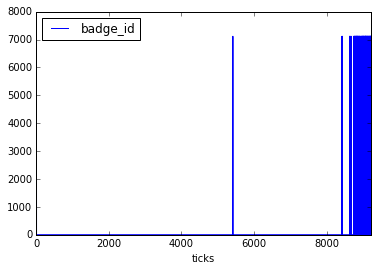

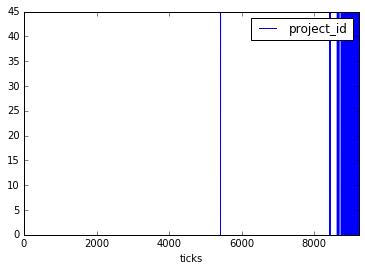

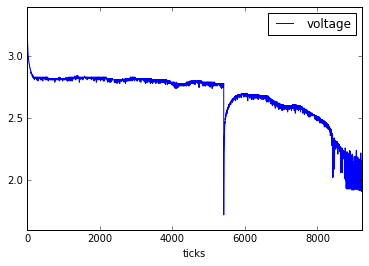

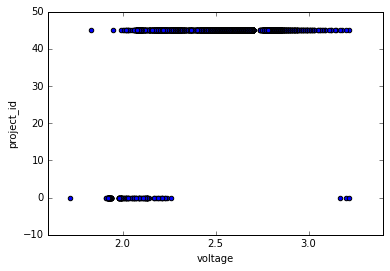

In [8]:
badge1 = table[table['mac']=='C8:CA:83:BE:F4:C6'].dropna(axis=0, how='any')
badge1['ticks']=range(0,len(badge1.index.values))
badge1.reset_index().plot(x='ticks', y='badge_id')
badge1.reset_index().plot(x='ticks', y='project_id')
badge1.reset_index().plot(x='ticks', y='voltage')
badge1.reset_index().plot.scatter(x='voltage', y='project_id')

In [19]:
badge1

,datetime,mac,rssi,voltage,badge_id,project_id,sync_status,audio_status,proximity_status,ticks
2,"2018-03-14 19:04:31,119",C8:CA:83:BE:F4:C6,-68.0,3.17,7115.0,0.0,0.0,0.0,0.0,0
9,"2018-03-14 19:05:06,485",C8:CA:83:BE:F4:C6,-64.0,3.20,7115.0,0.0,0.0,0.0,0.0,1
19,"2018-03-14 19:05:54,006",C8:CA:83:BE:F4:C6,-69.0,3.22,7115.0,0.0,0.0,0.0,0.0,2
29,"2018-03-14 19:06:41,940",C8:CA:83:BE:F4:C6,-69.0,3.22,4.0,45.0,1.0,1.0,1.0,3
39,"2018-03-14 19:07:29,510",C8:CA:83:BE:F4:C6,-72.0,3.20,4.0,45.0,1.0,1.0,1.0,4
49,"2018-03-14 19:08:18,640",C8:CA:83:BE:F4:C6,-68.0,3.18,4.0,45.0,1.0,1.0,1.0,5
59,"2018-03-14 19:09:11,009",C8:CA:83:BE:F4:C6,-65.0,3.17,4.0,45.0,1.0,1.0,1.0,6
69,"2018-03-14 19:10:04,115",C8:CA:83:BE:F4:C6,-70.0,3.15,4.0,45.0,1.0,1.0,1.0,7
79,"2018-03-14 19:10:55,033",C8:CA:83:BE:F4:C6,-62.0,3.14,4.0,45.0,1.0,1.0,1.0,8
89,"2018-03-14 19:11:43,735",C8:CA:83:BE:F4:C6,-70.0,3.12,4.0,45.0,1.0,1.0,1.0,9


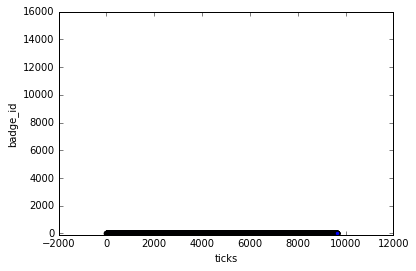

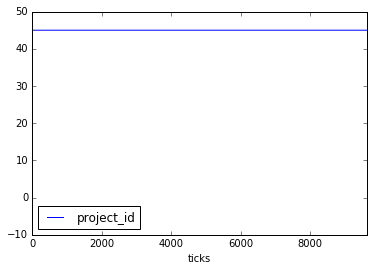

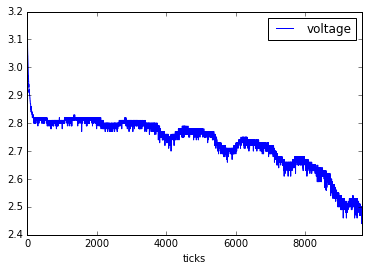

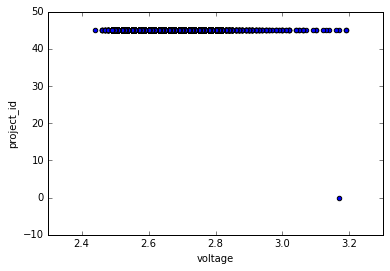

In [9]:
badge2 = table[table['mac']=='DA:49:9C:59:B0:83'].dropna(axis=0, how='any')
badge2['ticks']=range(0,len(badge2.index.values))
badge2.reset_index().plot.scatter(x='ticks', y='badge_id', ylim=[-100,16000])
badge2.reset_index().plot(x='ticks', y='project_id', ylim=[-10,50])
badge2.reset_index().plot(x='ticks', y='voltage')
badge2.reset_index().plot.scatter(x='voltage', y='project_id')

,datetime,mac,rssi,voltage,badge_id,project_id,sync_status,audio_status,proximity_status,ticks
11,"2018-03-14 19:05:06,488",E9:C1:D8:46:67:05,-67.0,3.18,65355.0,0.0,0.0,0.0,0.0,0
21,"2018-03-14 19:05:54,010",E9:C1:D8:46:67:05,-74.0,3.20,2.0,45.0,1.0,1.0,1.0,1
30,"2018-03-14 19:06:41,942",E9:C1:D8:46:67:05,-73.0,3.19,2.0,45.0,1.0,1.0,1.0,2
41,"2018-03-14 19:07:29,511",E9:C1:D8:46:67:05,-77.0,3.19,2.0,45.0,1.0,1.0,1.0,3
51,"2018-03-14 19:08:18,642",E9:C1:D8:46:67:05,-69.0,3.17,2.0,45.0,1.0,1.0,1.0,4
60,"2018-03-14 19:09:11,010",E9:C1:D8:46:67:05,-71.0,3.15,2.0,45.0,1.0,1.0,1.0,5
71,"2018-03-14 19:10:04,118",E9:C1:D8:46:67:05,-75.0,3.14,2.0,45.0,1.0,1.0,1.0,6
81,"2018-03-14 19:10:55,036",E9:C1:D8:46:67:05,-75.0,3.13,2.0,45.0,1.0,1.0,1.0,7
91,"2018-03-14 19:11:43,737",E9:C1:D8:46:67:05,-74.0,3.12,2.0,45.0,1.0,1.0,1.0,8
101,"2018-03-14 19:12:33,576",E9:C1:D8:46:67:05,-70.0,3.11,2.0,45.0,1.0,1.0,1.0,9


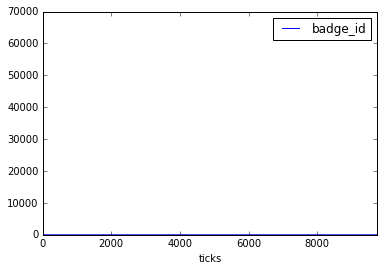

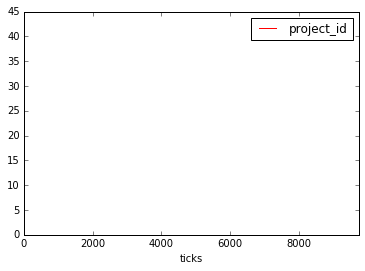

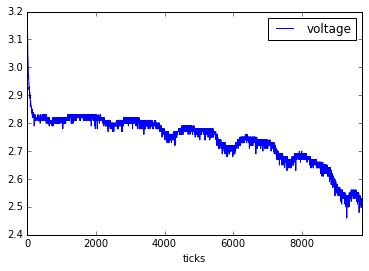

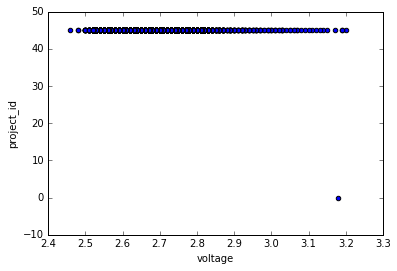

In [10]:
badge3 = table[table['mac']=='E9:C1:D8:46:67:05'].dropna(axis=0, how='any')
badge3['ticks']=range(0,len(badge3.index.values))
badge3.reset_index().plot(x='ticks', y='badge_id')
badge3.reset_index().plot(x='ticks', y='project_id',color='red')
badge3.reset_index().plot(x='ticks', y='voltage')
badge3.reset_index().plot.scatter(x='voltage', y='project_id')
badge3

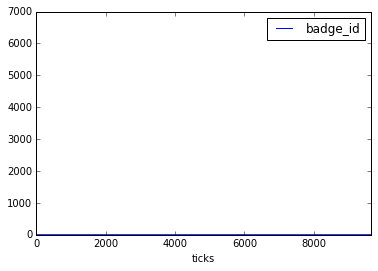

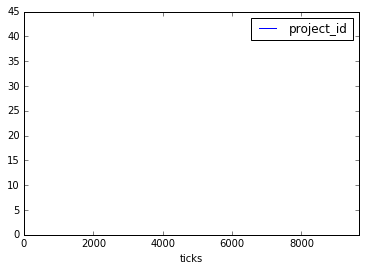

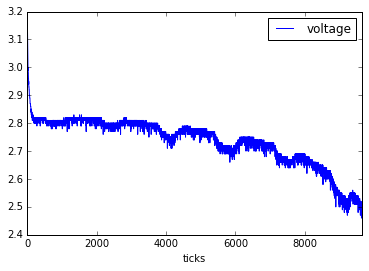

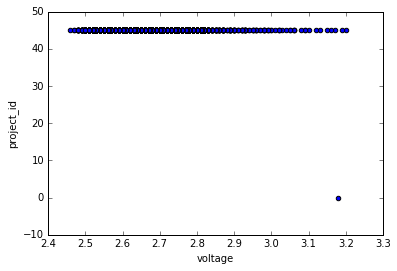

In [11]:
badge4 = table[table['mac']=='E8:1F:E4:93:2B:5B'].dropna(axis=0, how='any')
badge4['ticks']=range(0,len(badge4.index.values))
badge4.reset_index().plot(x='ticks', y='badge_id')
badge4.reset_index().plot(x='ticks', y='project_id')
badge4.reset_index().plot(x='ticks', y='voltage')
badge4.reset_index().plot.scatter(x='voltage', y='project_id')

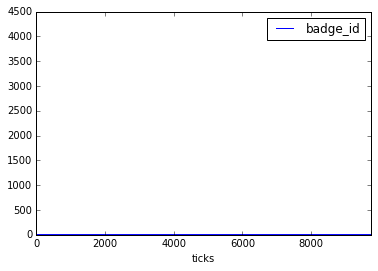

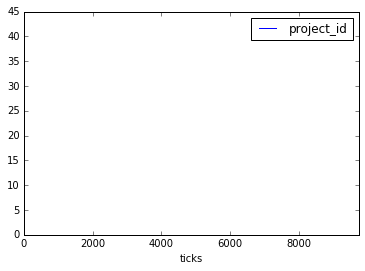

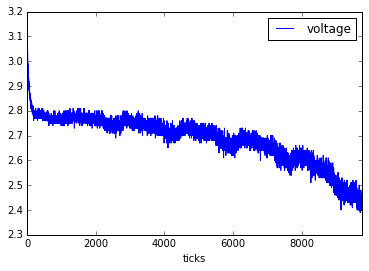

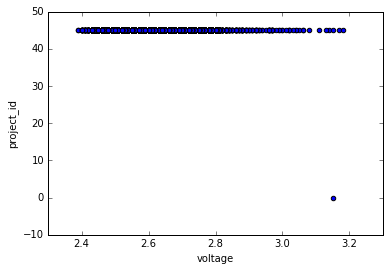

In [12]:
badge5 = table[table['mac']=='EE:2A:D2:F0:8D:29'].dropna(axis=0, how='any')
badge5['ticks']=range(0,len(badge5.index.values))
badge5.reset_index().plot(x='ticks', y='badge_id')
badge5.reset_index().plot(x='ticks', y='project_id')
badge5.reset_index().plot(x='ticks', y='voltage')
badge5.reset_index().plot.scatter(x='voltage', y='project_id')

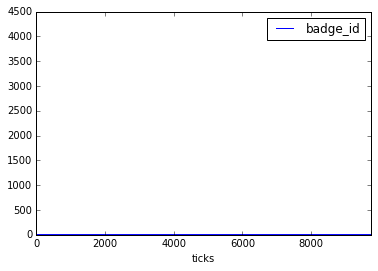

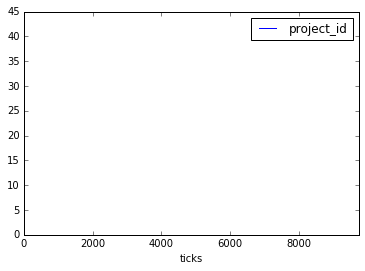

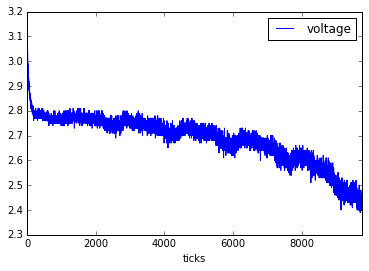

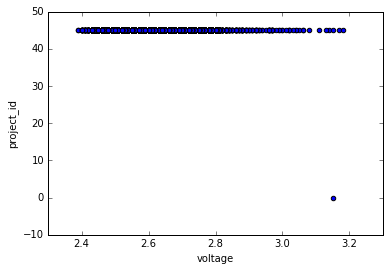

In [13]:
badge6 = table[table['mac']=='EE:2A:D2:F0:8D:29'].dropna(axis=0, how='any')
badge6['ticks']=range(0,len(badge6.index.values))
badge6.reset_index().plot(x='ticks', y='badge_id')
badge6.reset_index().plot(x='ticks', y='project_id')
badge6.reset_index().plot(x='ticks', y='voltage')
badge6.reset_index().plot.scatter(x='voltage', y='project_id')

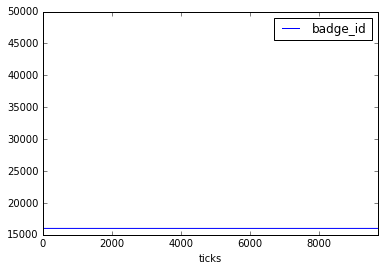

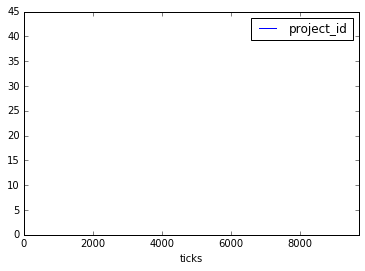

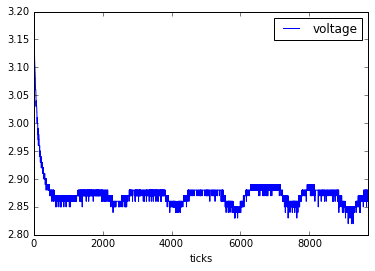

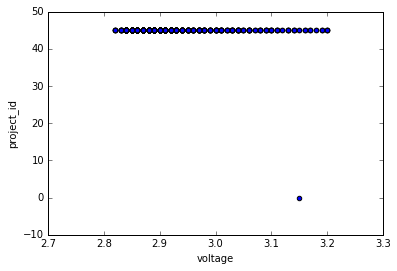

In [14]:
beacon1 = table[table['mac']=='EF:13:E7:6B:B2:4E'].dropna(axis=0, how='any')
beacon1['ticks']=range(0,len(beacon1.index.values))
beacon1.reset_index().plot(x='ticks', y='badge_id')
beacon1.reset_index().plot(x='ticks', y='project_id')
beacon1.reset_index().plot(x='ticks', y='voltage')
beacon1.reset_index().plot.scatter(x='voltage', y='project_id')

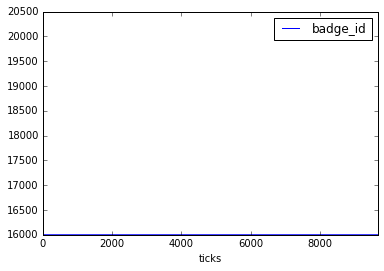

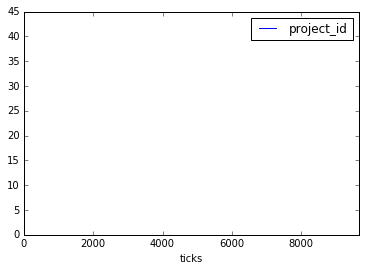

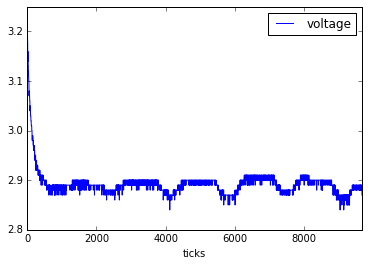

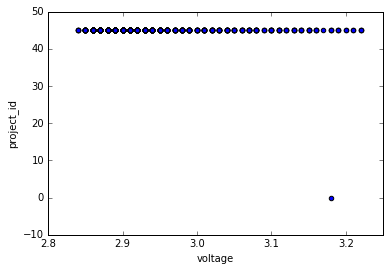

In [15]:
beacon2 = table[table['mac']=='DE:83:8F:7F:42:5E'].dropna(axis=0, how='any')
beacon2['ticks']=range(0,len(beacon2.index.values))
beacon2.reset_index().plot(x='ticks', y='badge_id')
beacon2.reset_index().plot(x='ticks', y='project_id')
beacon2.reset_index().plot(x='ticks', y='voltage')
beacon2.reset_index().plot.scatter(x='voltage', y='project_id')

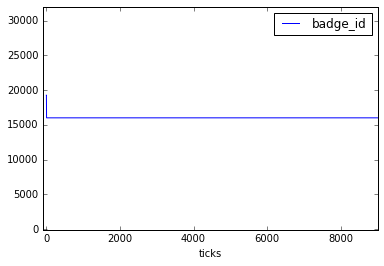

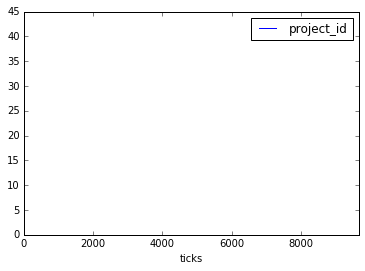

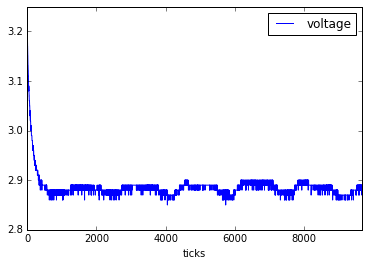

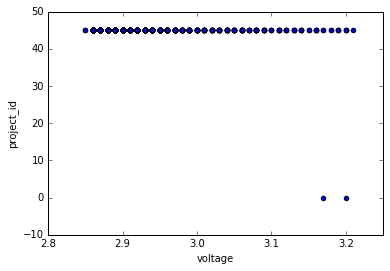

In [16]:
beacon3 = table[table['mac']=='CB:4A:90:1E:6B:23'].dropna(axis=0, how='any')
beacon3['ticks']=range(0,len(beacon3.index.values))
beacon3.reset_index().plot(x='ticks', y='badge_id',xlim=[-100,9000],ylim=[-100,32000])
beacon3.reset_index().plot(x='ticks', y='project_id')
beacon3.reset_index().plot(x='ticks', y='voltage')
beacon3.reset_index().plot.scatter(x='voltage', y='project_id')

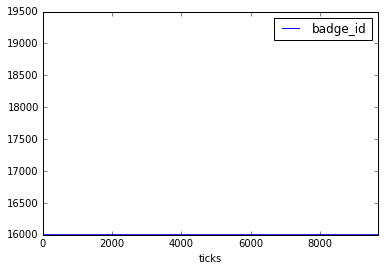

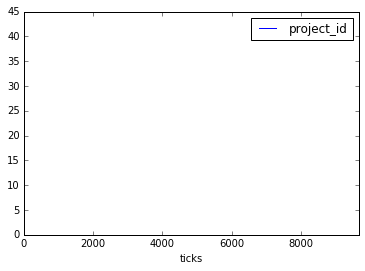

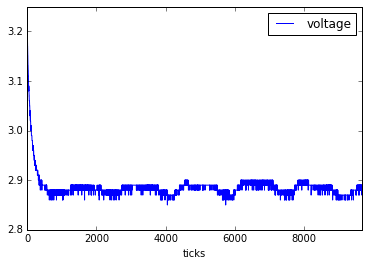

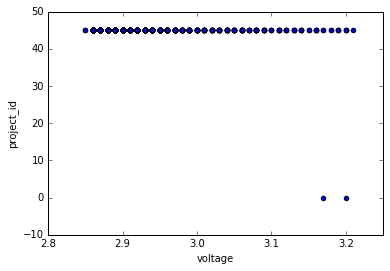

In [17]:
beacon4 = table[table['mac']=='CB:4A:90:1E:6B:23'].dropna(axis=0, how='any')
beacon4['ticks']=range(0,len(beacon4.index.values))
beacon4.reset_index().plot(x='ticks', y='badge_id')
beacon4.reset_index().plot(x='ticks', y='project_id')
beacon4.reset_index().plot(x='ticks', y='voltage')
beacon4.reset_index().plot.scatter(x='voltage', y='project_id')